In [ ]:
<img src="logo.png",width=200,height=200>

# Clasificación 
#### Clasificando observaciones en base a atributos exógenos

> __Alcance de la sesión__:
>
> * Conocer la regresión logística y sus fundamentos.
> * Conocer y ser capaz de interpretar estadísticos de bondad de ajuste y coeficientes.
> * Reconocer los supuestos en que tiene sustento teórico.
> * Implementar un modelo de regresión con `statsmodels`.
> * Implementar un modelo predictivo con `scikit-learn`.
> * Conocer los conceptos de validación cruzada y medidas de desempeño.


* En esta semana estudiaremos el problema de clasificación en Data Science, que busca esclarecer sobre los efectos que tienen los atributos en una variable categórica.
* Siguiendo la taxonomía de Hastie, Tibshinari y Friedman (2009), los problemas de clasificación corresponden a un ejemplo de aprendizaje supervisado donde el vector objetivo responde a un atributo discreto. Ejemplos de ello:
    - Movimientos del mercado: _¿Bajará o subirá la bolsa?_ $\leadsto Y_{i} \in \{0: Baja, 1: Sube\}$.
    - Clasificación de Spam: _¿Es este mail Spam o No?_ $\leadsto Y_{i} \in \{0: No, 1: Sí\}$.
    - Optimización de Preferencias: _¿Es más probable votar o no?_ $\leadsto Y_{i} \in \{0: No Vota, 1: Vota \}$
* Los ejemplos mencionados hacen referencia a un problema de clasificación binario, donde observamos la presencia o ausencia de un atributo. La aproximación de este fenómeno toma forma en un ensayo de Bernoulli.

In [92]:
# Imporatamos la triada clásica 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
# seaborn
import seaborn as sns
# scipy stats para simular
import scipy.stats as stats
# statsmodels para modelación
import statsmodels.api as sm
import statsmodels.formula.api as smf

import warnings
warnings.filterwarnings("ignore")

import lec6_graphs as gfx

plt.style.use('seaborn') # Gráficos estilo seaborn
# plt.rcParams["figure.figsize"] = (6, 3) # Tamaño gráficos
# plt.rcParams["figure.dpi"] = 200 # resolución gráficos

## Estimado probabilidades de éxito y fracaso

* La tarea de esta lectura es el uso de pozos de agua en Bangladesh. Resulta que el agua en Bangladesh y otros países del Sudeste Asiático está contaminada con [arsénico natural](https://www.nytimes.com/2005/07/17/us/the-lethal-water-wells-of-bangladesh.html). El riesgo del arsénico como cancerígeno y catalizador de otras enfermedades aumenta con la exposición prolongada. El gobierno de Bangladesh inició una estrategia nacional para la mitigación de riesgos asociados al arsénico. Una de las estrategias era el incentivar el uso compartido de pozos de napa subterránea, dado que presentan tasas de arsénico susbtancialmente menores.
* Usaremos una base de datos donde se registró si un hogar comenzó a utilizar un nuevo pozo de napa subterránea o no. Así, clasificaremos como 1 si el hogar se cambió a un pozo nuevo, 0 de lo contrario. Analizaremos la probabilidad de cambiarse o no en función a las siguientes variables:
    1. La distancia del hogar al pozo más cercano (medida en 100 metros) (`dist100`).
    - El nivel de arsénico del actual pozo en uso del hogar (`arsenic`).
    - El nivel educacional de el/la jefe/a de hogar (`educ4`).
    - Si algún miembro de la familia participa o no en asociaciones comunitarias (`assoc`).

* Importemos la base de datos con `pandas`.

In [93]:
# ingresamos la base de datos
df = pd.read_csv('wells.csv')
# La base de datos incluye una columna de índice. Eliminemosla para evitar futuros conflictos
df = df.drop("index", axis =1)

### Análisis exploratorio

* La base de datos se compone de 3020 observaciones y cinco columnas

In [94]:
print("La base de datos tiene ", df.shape[0], "observaciones y ", df.shape[1], " columnas")
print("Las variables de la base de datos son ", df.columns)

La base de datos tiene  3020 observaciones y  5  columnas
Las variables de la base de datos son  Index(['y', 'dist100', 'arsenic', 'educ4', 'assoc'], dtype='object')


* Solicitemos las medidas descriptivas de los datos con los que vamos a trabajar. Como ya sabemos que el método `describe` de pandas funciona sólo con las columnas numéricas, utilizaremos `value_counts` para las columnas con atributos discretos. 
* Esto lo implementamos en un `for` con un `if` para diferenciar si los atributos tiene más de dos niveles.

In [95]:
for i in df:
    if len(df[i].value_counts()) > 2:
        print(df[i].describe(), "\n")
    else:
        print(df[i].value_counts('%'), "\n")

1    0.575166
0    0.424834
Name: y, dtype: float64 

count    3020.000000
mean        0.483319
std         0.384787
min         0.003870
25%         0.211172
50%         0.367615
75%         0.640410
max         3.395310
Name: dist100, dtype: float64 

count    3020.000000
mean        1.656930
std         1.107387
min         0.510000
25%         0.820000
50%         1.300000
75%         2.200000
max         9.650000
Name: arsenic, dtype: float64 

count    3020.000000
mean        1.207119
std         1.004329
min         0.000000
25%         0.000000
50%         1.250000
75%         2.000000
max         4.250000
Name: educ4, dtype: float64 

0    0.577152
1    0.422848
Name: assoc, dtype: float64 



In [96]:
df.describe()

,y,dist100,arsenic,educ4,assoc
count,3020.000000,3020.000000,3020.000000,3020.000000,3020.000000
mean,0.575166,0.483319,1.656930,1.207119,0.422848
std,0.494400,0.384787,1.107387,1.004329,0.494093
min,0.000000,0.003870,0.510000,0.000000,0.000000
25%,0.000000,0.211172,0.820000,0.000000,0.000000
50%,1.000000,0.367615,1.300000,1.250000,0.000000
75%,1.000000,0.640410,2.200000,2.000000,1.000000
max,1.000000,3.395310,9.650000,4.250000,1.000000


* Respecto a las variables con atributos discretos (nuestra variable dependiente `y`, y `assoc`), observamos que alrededor del 58% de las familias componentes de la muestra se cambiaron de pozo a uno más seguro. Encontramos lo opuesto con `assoc`, cerca del 58% de los jefe de hogar en la familia no participan en asociaciones comunitarias. El nivel educacional de los encuestados se mide en el máximo grado académico desde 0 (Sin educación formal) a 4 (Secundaria completa). La media reportada sugiere que gran parte de la población posee niveles bajos de educación.
* La mayoría de las familias se sitúan en una distancia de 48 metros de un pozo seguro, y el nivel de arsénico promedio en el agua es de 1.65, entre el rango de .51 y 9.65, lo cual es relativamente bajo.
* Para tener una mejor perspectiva del comportamiento de las columnas, vamos a graficarlas con histogramas para las contínuas y gráficos de barra las discretas.

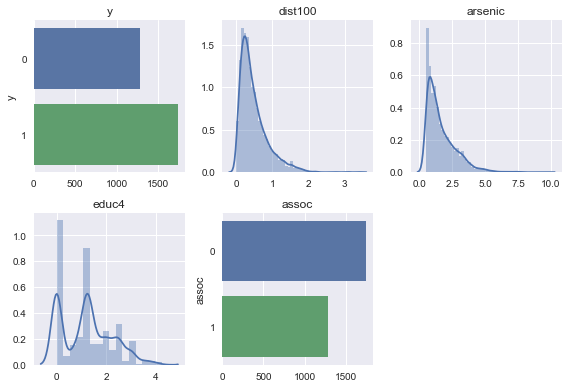

In [97]:
for n, i in enumerate(df):
    plt.subplot(2, 3, n+1)
    if len(df[i].value_counts()) > 2:
        sns.distplot(df[i])
        plt.title(i)
        plt.xlabel("")
    else:
        sns.countplot(y=df[i])
        plt.title(i)
        plt.xlabel("")
    plt.tight_layout()

* Observamos que para `dist100`, `arsenic` y `educ4` existe un sesgo hacia los valores bajos, lo cual sugiere que los casos donde la distancia y el nivel de arsénico son substancialmente grandes son relativamente anómalos.
* Respecto a las variables discretas, observamos que las clases están relativamente bien equilibradas, lo cual facilita nuestra modelación.
> __Digresión__: ¿Qué hacer ante clases desbalanceadas?
>
> Existe una serie de mecanismos alternativos para mitigar el efecto del desbalance en las clases:
> 1. Asumir que el componente estocástico del modelo se puede representar de mejor manera mediante una distribución Poisson, Binomial Negativa o Cero Dispersa.
> - Utilizar errores robustos (Huber-White sandwich) para fortalecer la matriz de varianza-covarianza.
> - Estimar el modelo con robit (regresión logística t-distribuída) por sobre logit.
> - Recolectar más datos en la medida que sea posible.
> - Remuestrear sobre la muestra para disminuir el desbalance:
>> - __Over-sampling:__ Remuestrear copias de la clase sub-representada a la muestra original.
>> - __Under-sampling:__ Eliminar instancias de la clase sobrerepresentada.

* Ahora visualizemos las correlaciones mediante una matriz. Seaborn presenta el método `sns.heatmap()` para generar un gráfico sobre la intensidad de las asociaciones entre las variables de una base de datos. Los parámetros ingresados son:
    1. `df.corr()` ingresamos las correlaciones calculadas mediante `pandas`.
    - `cmap='Blues'` define el rango de colores. En este caso utilizaremos una gama de azules.
    - `annot=True` añadirá el puntaje de la correlación sobre cada celda.

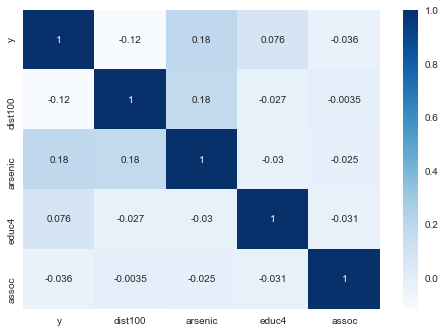

In [98]:
sns.heatmap(df.corr(), cmap='Blues', annot=True);

* Los resultados de la matriz de correlación pueden ser desalentadores, dado que no hay asociaciones fuertes entre las variables. Por defecto utilizamos la correlación de pearson, que no tiene un buen desempeño con variables que no sean estrictamente normales. Como ya se ha mencionado antes, ésto no es un impedimiento para seguir con la modelación ya que muchas relaciones no son estrictamente lineales.


## El modelo de probabilidad lineal

* Una primera aproximación al problema de clasificación binario es utilizar una regresión lineal, asumiendo que en nuestra variable dependiente estaremos midiendo la __probabilidad__ del suceso.

$$
\texttt{y}_{i} = \beta_{0} + \beta_{1}\times\texttt{dist100} + \varepsilon_{i}
$$

* Este modelo se conoce como __modelo de probabilidad lineal__, donde implementamos una regresión lineal con nuestra variable dependiente binaria. Los parámetros estimados afectan la _probabilidad que el evento suceda_. Con nuestro $\hat{Y}$ predicho podemos clasificar una observación como 1 si $\hat{Y} > 0.5$, de lo contrario 0.

In [99]:
# ejecutemos nuestro modelo
m1_ols = smf.ols('y ~ dist100', df).fit()

* Ahora vamos a generar una función para obtener sólo los parámetros necesarios en nuestro modelo. La función `concise_summary()` necesita como argumento el modelo estimado con `statsmodels` y devolverá sólo algunas características esenciales del modelo.

In [100]:
def concise_summary(mod, print_fit=True):
    #guardamos los parámetros asociados a estadísticas de ajuste
    fit = pd.DataFrame({'Statistics': mod.summary2().tables[0][2][2:],
                       'Value': mod.summary2().tables[0][3][2:]})
    # guardamos los parámetros estimados por cada regresor.
    estimates = pd.DataFrame(mod.summary2().tables[1].loc[:, 'Coef.': 'Std.Err.'])
    # imprimir fit es opcional
    if print_fit is True:
        print("\nGoodness of Fit statistics\n", fit)
    
    print("\nPoint Estimates\n\n", estimates)

# solicitemos las características del modelo
concise_summary(m1_ols)


Goodness of Fit statistics
             Statistics      Value
2                 BIC:  4288.4686
3      Log-Likelihood:    -2136.2
4         F-statistic:      42.57
5  Prob (F-statistic):   7.95e-11
6               Scale:    0.24111

Point Estimates

               Coef.  Std.Err.
Intercept  0.648407  0.014347
dist100   -0.151539  0.023225


* Una de las primeras preguntas que nos hacemos es __¿dónde está nuestro R-cuadrado?__ Resulta que no es tan relevante para nuestro modelo, dado que mide simplemente la capacidad explicativa de la variabilidad de $Y$ dado un conjunto de variables explicativas. Preferimos concentrarnos en aspectos menos triviales como si por lo menos uno de nuestros parámetros es distinto a cero, que se mide con `Prob (F-statistic)`. Aspectos como el BIC (Bayesian Information Criteria) y el Log-Likelihood son más informativos sobre la optimización de nuestro método que el R-cuadrado. 
* Respecto a los puntos estimados, nuestra función reporta sólo el coeficiente y su error estandar asociado. La interpretación de los coeficientes en este modelo son:

- El intercepto ($\beta_{0}$) se puede interpretar al considerar `dist100=0`. Una familia que esté a 0 metros de distancia de un pozo tendrá una probabilidad del 65% de cambiarse de pozo (asumiendo que está limpio).
    
    - El tema es que la función `concise_summary` no devuelve nuestra significancia estadística. Para obtener el puntaje z, simplemente dividimos el parámetro estimado por su desviación estandar. En este caso $z= 0.648 /0.014 = 46.28$. Al ser superior a los puntajes de corte, existe evidencia para rechazar la hipótesis nula al 95%.
    
- `dist100` ($\beta_{1}$) se puede interpretar como la diferencia entre dos individuos que tienen similares características pero difieren _en 100 metros de distancia de un pozo seguro_, conlleva a una disminución de un 15% en la probabilidad de cambiarse de pozo. El parámetro es significativo con un z de  $z= -0.151 /0.023 = -6.56$ es superior a los puntos críticos por lo que existe evidencia para rechazar la hipótesis nula.



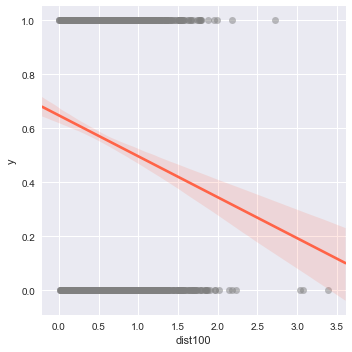

In [101]:
sns.lmplot('dist100','y', df, 
           line_kws={'color':'tomato'},
           scatter_kws={'color': 'grey', 'alpha': .5});

* Podemos visualizar la relación entre ambas variables con `sns.lmplot`, que solicita el eje x `dist100` y la dependiente `y`. Los argumentos `line_kws` y `scatter_kws` gobiernan los elementos visuales de los puntos y la recta. De forma intuitiva se demuestra que en la medida que la probabilidad de cambiarse de pozo disminuye en la medida que la familia se encuentra más alejada de un pozo.

* Una de las ventajas del modelo de probabilidad lineal es la facilidad de su interpretación, dado que los coeficientes hacen referencia al cambio en una unidad de X afecta a la probabilidad $\text{Pr}(y=1)$. Lamentablemente, no está exento de problemas. Alguno de estos:
    1. Los parámetros estimados $x_{i}\beta$ pueden tomar valores mayores que 1 y menores que 0, lo cual va más allá de los límites razonables de la probabilidad.
    - Los errores no siguen una distribución normal, dado que pueden tomar sólo dos valores. Los errores nunca podrán estar normalmente distribuídos.
    - La forma funcional impuesta por el modelo lineal restringe las nolinealidades en los extremos de la distribución de la muestra.

## Regresión Logística al rescate

* Si bien nuestro estimador LPM es intuitivo, presenta fallas severas en la estimación. La regresión logística permite generar estimaciones mediante el __método de máxima verosimilitud__ y toma en consideración los problemas anteriormente vistos. Los detalles sobre el método de máxima verosimilitud se los dejaremos a Python :).
* Resulta que nuestro objetivo es desarrollar un modelo predictivo para la probabilidad de ocurrencia de Y ($\text{Pr}(x)=\text{Pr}(Y =1 \vert X = x)$).

$$
\log\left(\frac{p(x)}{1 - p(x)}\right) = \beta_0 + \beta_{1}\times\texttt{dist100}
$$

* Implementar la regresión logística con `statsmodels` es similar a la implementación del modelo de regresión lineal. Necesitamos declarar la ecuación como un string y definir el objeto donde `statsmodels` buscará las variables.
* El método requiere que nuestra variable dependiente sea binaria. Los regresores independientes pueden ser contínuos y/o categóricos.

In [102]:
m1_logit = smf.logit('y ~ dist100', df).fit()
concise_summary(m1_logit)

Optimization terminated successfully.
         Current function value: 0.674874
         Iterations 4

Goodness of Fit statistics
         Statistics      Value
2             AIC:  4080.2378
3             BIC:  4092.2639
4  Log-Likelihood:    -2038.1
5         LL-Null:    -2059.0
6           Scale:     1.0000

Point Estimates

               Coef.  Std.Err.
Intercept  0.605959  0.060310
dist100   -0.621882  0.097426


### ¿Y qué significa todo esto para nosotros?

* Podríamos estar tentados a interpretar los coeficientes como:

> "La diferencia entre dos individuos que tienen similares características pero difieren _en 100 metros de distancia de un pozo seguro_, conlleva a una disminución de un .62 en la probabilidad de cambiarse de pozo.

* Esto esta mal, dado que los parámetros estimados mediante la regresión logística se conocen como _log-odds_, que representan el logaritmo de la chance de ocurrencia de un evento en específico. Esto obliga a tomar con cautela el cómo se deben interpretar. La intepretación de arriba tiene sentido cuando hablamos del _logaritmo de la chance de ocurrencia_, lo cual resulta difícil de entender.

> __Digresión:__ Chance de ocurrencia es distinto a probabilidad.
>
> Aunque en el ámbito cotidiano se utiliza *'chance de ocurrencia'* (Odds) y *'probabildad'*(probability) como sinónimos, en estadística (y en especial en teoría de juegos) estos dos conceptos son distintos, aunque están fuertemente relacionados entre si:
>
> La __probabilidad__ de que ocurra un suceso se define (clásicamente) de manera empírica, es decir:
>
> $$
p(x) = \frac{\text{Nº de ocurrencias de x}}{\text{Casos totales medidos}}
$$
>
> La __chance__ de que ocurra ese mismo suceso es:
>$$
Odd(x) = \frac{p(x)}{1-p(x)}
$$
> La diferencia entre __chance de ocurrencia__ y __probabilidad__ es que la chance de ocurrencia nos dice qué tanto del espacio de eventos posibles está siendo utilizado por el evento de interés, mientras que la probabilidad nos dice qué tan "seguros" podemos estar el resultado final. Por ejemplo, imaginemos que vamos a una casa de apuestas de caballos y nos enteramos que al caballo _'Lucky Luke'_ ha ganado 30 de las 100 carreras que ha corrido, luego, la probabilidad de que _'Lucky Luke'_ gane la siguiente carrera es de $30/100 = 0.30$, mientras que las chances de que gane son de $0.30/(1-0.30) = 0.43$, o dicho más cotidianamente, 3 victorias a 7 derrotas. Finalmente, notar que las chances de ganar pueden ser un número en todo el intervalo $[0,∞+]$, lo cuál es justo lo que necesitamos para poder utilizar la regresión lineal en este caso donde nuestra recta de separación entre las clases debe poder extenderse más allá del rango $[0, 1]$ que nos entrega la medída de probabilidad.
>
> Esta última relación matemática nos da la razón de existencias de ese logaritmo en la expresión presentada al inicio de esta sección: __Aplicar la función _´logit´_ a la probabilidad nos entrega el logaritmo de las chances (odds)__.

* El objetivo es traducir los valores del log odds en una declaración de probabilidad entre 0 y 1. Así se genera una explicación intuitiva sobre el efecto de una variable _en la probabilidad de ocurrencia_ (por sobre el efecto de una variable _en el logaritmo de la chance de ocurrencia_). Para ello utilizamos la función _logística inversa_ (presentada como $\text{logit}^{-1}(x)=\frac{exp(x)}{1+exp(-x)}$).


* Supongamos que deseamos saber la probabilidad de cambiarse a un pozo seguro _para toda la muestra_. En base a nuestro modelo estimado, podemos obtener la probabilidad con los siguientes pasos:

__1. Calcular el log odds promedio cuando dist100 es igual al promedio__

* Primero debemos reemplazar valores en nuestra ecuación para interpolar el punto predicho cuando `dist100` toma el promedio:

$$
\text{Pr}(\text{CambioPozo} =1 \vert X) = \text{log}\left(\frac{exp(\beta_0 + \beta_1)}{1-exp(\beta_0 + \beta_1)}\right)
$$

Esto lo podemos aplicar de la siguiente manera:

In [103]:
# guardamos la media en un objeto
dist100_mean = df['dist100'].mean()
print("La media es de ", round(dist100_mean, 2))

# accedemos a los parámetros con la sintáxis modelo.params['parametro]
estimate_y = m1_logit.params['Intercept'] + (m1_logit.params['dist100'] * dist100_mean)
print("El log odds estimado es de ", round(estimate_y, 2))

La media es de  0.48
El log odds estimado es de  0.31


__2. Convertir nuestro log odds estimado en una probabilidad__

* Este punto estimado debemos traducirlo a una probabilidad por medio de la función logística inversa, que definimos en Python como una función:

In [104]:
def invlogit(x):
    return 1 / (1+np.exp(-x))

print("La probabilidad promedio de cambiarse de pozo cuando tenemos una distancia de 48 metros es: ", 
      round(invlogit(estimate_y), 2))

La probabilidad promedio de cambiarse de pozo cuando tenemos una distancia de 48 metros es:  0.58


* Realizar el mapeo de log odds a probabilidades puede ser tedioso, pero le damos mucho más sentido a nuestro modelo.

### Calculando el efecto diferencial 

* También podemos estar interesados en el cambio en la probabilidad cuando nuestro $x$ aumenta en 1 unidad. Esto se asemeja a nuestra conceptualización clásica del coeficiente estimado en la regresión lineal.
* De manera similar a como lo hicimos con el efecto promedio, debemos generar las funciones logísticas inversas para estimar la probabilidad de __dos eventos__, mediante los cuales simularemos el cambio en la probabilidad cuando nuestro $x$ cambia en una unidad.
* Vamos a generar cuatro escenarios donde se estimará la probabilidad de cambio para 100, 200, 300 y 400 metros.

In [105]:
pr_dist_100 = invlogit(m1_logit.params['Intercept'] + (m1_logit.params['dist100'] * 1))
pr_dist_200 = invlogit(m1_logit.params['Intercept'] + (m1_logit.params['dist100'] * 2))
pr_dist_300 = invlogit(m1_logit.params['Intercept'] + (m1_logit.params['dist100'] * 3))
pr_dist_400 = invlogit(m1_logit.params['Intercept'] + (m1_logit.params['dist100'] * 4))

* Si deseamos ver cuál es el cambio de la probabilidad en una unidad, restamos dos unidades estimadas. Las líneas de abajo 

In [106]:
print("La probabilidad de cambiar de pozo entre 100 y 200 metros: ", round(pr_dist_100 - pr_dist_200, 3))
print("La probabilidad de cambiar de pozo entre 200 y 300 metros: ", round(pr_dist_200 - pr_dist_300, 3))
print("La probabilidad de cambiar de pozo entre 300 y 400 metros: ", round(pr_dist_300 - pr_dist_400, 3))

La probabilidad de cambiar de pozo entre 100 y 200 metros:  0.15
La probabilidad de cambiar de pozo entre 200 y 300 metros:  0.125
La probabilidad de cambiar de pozo entre 300 y 400 metros:  0.089


* Se observa que el tránsito entre distintos valores conlleva a distintos cambios en las probabilidades. Este es uno de los principales motivos de esta cautela en la interpretación del modelo logístico: __No se puede asumir monotonicidad estricta en los parámetros__. La probabilidad de un cambio entre 200 y 300 ($\text{Pr}(x)=.124$) es distinta a la probabilidad entre 300 y 400 ($\text{Pr}(x)=.088$).

* Podemos visualizar la estimación logística mediante el método `sns.lmplot`, incluyendo un argumento `logistic=True` que estimará la recta de ajuste en función a los log-odds.
* La línea azul vertical se conoce como el límite de decisión, situación hipotética donde una observación tiene iguales chances del evento en cuestion. 
* En este este caso, cuando una familia se encuentre aproximadamente a 97 metros de un pozo seguro, tendrán iguales chances de cambiarse o no. Para estimar el límite de decisión, se utiliza la siguiente fórmula:

$$
x_1 = \frac{-\hat{\beta}_0}{\hat{\beta}_1}.
$$

Una observación tiene igual probabilidad en ambos sucesos cuando x =  0.974


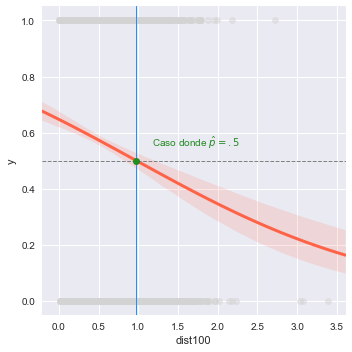

In [107]:
sns.lmplot('dist100', 'y', df,
           logistic=True,
           line_kws={'color':'tomato', 'lw': 3},
           scatter_kws={'color': 'lightgrey', 'alpha': .5})

decision_boundary = - m1_logit.params['Intercept'] / m1_logit.params['dist100']
plt.axvline(decision_boundary, lw=1, color='dodgerblue')
plt.axhline(.5, linestyle='--', color='grey', lw=1)
plt.text(decision_boundary+.2, .5+.05, r'Caso donde $\hat{p}=.5$', color='forestgreen')
plt.plot(decision_boundary, .5, 'o', color='forestgreen')


print("Una observación tiene igual probabilidad en ambos sucesos cuando x = ", round(decision_boundary, 3));

### Relación entre LPM y Logit

* Dado que sabemos la ideonidad del modelo logístico para los casos binarios, ¿Por qué utilizamos el modelo de probabilidad lineal?
* Resulta que podemos tomar los log-odds de un modelo logístico y dividirlos por cuatro para obtener un intervalo superior de la contribución de x en y cuando cambia en una medida. Este punto es una aproximación al comportamiento estimado en el medio de la curva logística donde las probabilidades son cercanas la .5.

>__Digresión:__ Aspectos formales de la regla _dividir en 4_
>
> * Resulta que la curva logística es más pronunciada en el centro, donde $\beta_{0}+\beta_{1}x = 0$, y su función logística inversa es $\text{logit}^{-1}(\beta_{0}+\beta_{1}x)=0.5$.
> * La derivada de la función lineal se maximiza en este punto con un valor de $\beta_{1}\text{exp}(0)/(1 + \text{exp}(0))^{2} = \beta_{1}/4$.
* Así $\beta_{1}/4$ es la diferencia máxima de $Pr(y=1|x)$. 

* Tomemos los coeficientes de nuestro modelo $\texttt{y} = \beta_{0} + \beta_{1}\times\texttt{dist100}$ para ambos modelos.

In [108]:
print("\nOLS")
concise_summary(m1_ols, print_fit=False)
print("\nLogit")
concise_summary(m1_logit, print_fit=False)


OLS

Point Estimates

               Coef.  Std.Err.
Intercept  0.648407  0.014347
dist100   -0.151539  0.023225

Logit

Point Estimates

               Coef.  Std.Err.
Intercept  0.605959  0.060310
dist100   -0.621882  0.097426


* Si dividimos el coeficiente estimado de nuestra regresión logística $-.62 / 4 = .15$, veremos que es una aproximación razonable del coeficiente estimado en nuestro modelo LPM.
* Este coeficiente corresponde a la máxima diferencia contribuída por x en $Pr(y=1|x)$. Si revisamos nuestros efectos estimados, observaremos que el .15 estimado corresponde a la diferencia en un 15% de probabilidad entre una familia que está a 100 metros de distancia y otra que está a 200 metros de distancia de un pozo seguro.

In [109]:
print("La probabilidad de cambiar de pozo entre 100 y 200 metros: ", round(pr_dist_100 - pr_dist_200, 3))

La probabilidad de cambiar de pozo entre 100 y 200 metros:  0.15


# El problema de clasificación desde Machine Learning

* El objetivo de la clasificación es enseñarle a la máquina a discriminar entre un número finito de clases en base a una serie de atributos. Para aproximarnos a este problema diseñamos una serie de __aproximaciones funcionales__ candidatas para facilitar la discriminación entre las clases.
* El objetivo es realizar predicciones en nuevas observaciones en base a la función candidata que presente el mejor desempeño predictivo. Mientras que en los problemas de regresión el desempeño se medía mediante la reducción del error cuadrático, en la clasificación se busca aumentar la tasa de clases predichas correctamente y reducir los __falsos positivos__ (situaciones donde se clasifica de forma errónea) y __falsos negativos__ (situaciones donde el clasificador ignora clasificaciones exitosas).

## Implementando un modelo logístico con `sklearn`

* Utilizaremos la clase `LogisticRegression` dentro del módulo `linear_model` de `sklearn`. Como todo modelo candidato de `sklearn`, seguimos los pasos de inicializarlo al ingresar datos y posteriormente ejecutarlo.
* Partamos por segmentar nuestra base de datos en entrenamiento y validación siguiendo la nomenclatura clásica, guardando el 33% de la muestra como validación. Recuerden especificar una semilla pseudoaleatoria con `random_state` para asegurar replicabilidad de los resultados.

In [110]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.loc[:, 'dist100':'assoc'],
                                                   df['y'],
                                                   test_size=.33,
                                                   random_state=11238)

* De forma adicional estandarizaremos cada atributo en nuestras muestras mediante `StandardScaler` en el módulo `sklearn.preprocessing`. Mediante la estandarización transformamos las variables al restarle la media y dividirla por la varianza de la variable.
* Con esto logramos homogeneizar las variables y facilitar la comparación entre atributos en el modelo logístico.
* Generamos nuevos objetos llamados `X_train_std` y `X_test_std` que guardaran las nuevas matrices. Estos objetos alojarán el resultado de `StandardScaler().fit_transform()`.

In [111]:
from sklearn.preprocessing import StandardScaler

# estandarizamos la matriz de entrenamiento
X_train_std = StandardScaler().fit_transform(X_train)
# estandarizamos la matriz de validación
X_test_std = StandardScaler().fit_transform(X_test)

# iniciamos el modelo con la clase LogisticRegression y pasamos los datos en fit.
default_model = LogisticRegression().fit(X_train_std, y_train)

* Al solicitar los coeficientes del modelo, observamos que son distintos a los estimados con nuestro modelo econométrico dado que no están estandarizados.

In [112]:
default_model.coef_

array([[-0.33263063,  0.59061437,  0.14254114, -0.05194878]])

* Procedemos por generar las predicciones en base a nuestro modelo mediante `predict(X_test_std)`. Cabe destacar que los modelos de clasificación presentan fórmulas alternativas de predicción.
* Mientras que con la opción `predict` solicitamos las clases en las nuevas observaciones, si solicitamos `predict_proba` obtendremos el mapeo $\text{Pr}(y^{*})\mapsto[0, 1]$, lo cual nos será útil cuando midamos tasas de falsos positivos y negativos en el modelo. Por último también está la opción `predict_log_proba` que devuelve el logaritmo de la probabilidad generada con `predict_proba`.

In [113]:
yhat = default_model.predict(X_test_std)
# solicitemos las primeras 20 observaciones del vector predicho.
yhat[:20]

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1])

* Hasta el momento nuestro flujo de trabajo es idéntico al problema de regresión. Resulta que la principal diferencia entre ambas aproximaciones es cómo evaluarmos su desempeño.

## Métricas de desempeño para las tareas de clasificación

* Ya sabemos que parte importante de nuestro flujo de trabajo desde Machine Learning busca analizar el desempeño del modelo en la predicción con nuevas observaciones. Para el caso de los modelos donde nuestro vector objetivo era contínuo utilizabamos el Promedio del Error Cuadrático, que cuantificaba qué tan separados están los datos de nuestra recta de ajuste predictivo.
* Resulta que para los casos donde nuestro vector objetivo presenta atributos discretos las métricas conocidas fallan en capturar el fenómeno. Los modelos predictivos generan dos tipos de predicciones de utilidad:
    1. Una predicción de probabilidad contínua entre los límites de cero y uno.
    - Una predicción de clase, que establece cuál es la clase más adecuada para una nueva observación.
* Para medir el desempeño de éstos modelos, nos centramos en la predicción de clase.

### Matriz de Confusión

* Una de las maneras más comunes de evaluar desempeño es el cruzar la información de la predicción con las etiquetas reales de nuestra muestra de validación. Esto se conoce como _matriz de confusión_, y permite observar la cantidad de observaciones predichas de forma correcta.
* `sklearn` tiene el método `confusion_matrix` en su módulo `metrics` que permite desarrollar este cruce de información. Este procedimiento se puede realizar de forma alternativa con `pd.crosstab()`. El método pide como argumentos el vector objetivo de prueba (`y_test`) y el vector de etiquetas predichas (`yhat`).

In [114]:
from sklearn.metrics import confusion_matrix

m1_confusion = confusion_matrix(y_test, yhat)
m1_confusion

array([[171, 251],
       [117, 458]])

In [115]:
# comparemos con pd.crosstab
m1_conf_pd = pd.crosstab(y_test, yhat)
m1_conf_pd

col_0,0,1
y,,
0,171,251
1,117,458


* La tabla resultante permite observar las categorías predichas con las observadas. La diagonal principal reporta los casos exitosamente predichos. Una de las primeras medidas de desempeño es medir el porcentaje de casos predichos correctamente por sobre el total de casos.
* Esta medida se conoce como __Accuracy (Exactitud)__:

|   | Categoría| Verdadera|
|---|----------|----------|
|**Predicción** | Verdadero | Falso |
|Verdadero | **Verdadero Positivo** | _Falso Positivo_ |
| Falso | _Falso Negativo_ | ** Verdadero Negativo **|


$$
\text{Exactitud} = \frac{\text{Verdadero Positivo + Verdadero Negativo}}{\text{Verdadero Positivo + Verdadero Negativo + Falso Positivo + Falso Negativo}}
$$

* `sklearn` implementa el método `accuracy_score` en el módulo `metrics`. El método pide como argumentos el vector objetivo de prueba (`y_test`) y el vector de etiquetas predichas (`yhat`) y devuelve un valor entre 0 y 1, donde valores más altos reflejan mayores niveles de concordancia entre ambos vectores.

In [116]:
from sklearn.metrics import accuracy_score
m1_acc = accuracy_score(y_test, yhat)
m1_acc

0.6308926780341023

* La métrica reportada de _.631_ sugiere cierta exactitud de nuestro modelo. El problema es que no sabemos frente a qué criterio nuestro modelo es eficiente. Para evaluar su desempeño necesitamos encontrar un _benchmark_ (punto de referencia) que refleje capacidad de predicción _al azar_, sin la necesidad de un modelo.
* La manera más simple de calcular un benchmark es dividir 1 por la cantidad de categorías en nuestro vector objetivo. De esta manera obtenemos un aproximado de la predicción correcta al azar.
* Para nuestro caso con la variable binaria, el benchmark es de $1/2=.5$. Nuestra medida de exactitud informa que el modelo tiene un desempeño de un 13% superior que una predicción azarosa.

* Resulta que la medida de exactitud por sí sola es engañosa, dado que no hace distinción alguna frente a los tipos de errores (_Falso Negativo_ y _Falso Positivo_). Para ello utilizamos dos medidas extras:

* Precision: Mide la fracción de predicciones correctas entre las etiquetas positivas. Valores altos significan que el algoritmo predice más resultados relevantes que irrelevantes. Responde a la pregunta: __¿Qué proporción de indentificaciones positivas fue correcta?__.

$$
\text{Precision} = \frac{\text{Verdadero Positivo}}{\text{Verdadero Positivo + Falso Positivo}}
$$


* Recall (o sensibilidad): Mide la fraccion de verdaderos positivos predichos por el modelo. Valores altos significan que el algoritmo logra predecir la mayoría de los resultados relevantes. Responde a la pregunta: __¿Qué proporción de positivos reales se identificó correctamente?__.

$$
\text{Recall} = \frac{\text{Verdadero Positivo}}{\text{Verdadero Positivo + Falso Negativo}}
$$

In [117]:
from sklearn.metrics import precision_score, recall_score
m1_prec = precision_score(y_test, yhat)
m1_rec = recall_score(y_test, yhat)
print("Precision: ", m1_prec, "\nRecall: ", m1_rec)

Precision:  0.6459802538787024 
Recall:  0.7965217391304348


* Los puntajes de precision y recall para el modelo sugieren que el modelo tiene un desempeño aceptable, pero que se puede mejorar de forma substancial. Un punto a destacar es la alta tasa de recall que tiene, rescatando gran parte de los valores etiquetados como 1.

* Existe un trueque entre Precision y Recall, en la medida que ambos puntajes se pueden promediar para obtener una medida ponderada de ambos fenómenos. 
* Esta medida se conoce como F1, y representa la media armónica entre Precision y Recall. Se prefiere la media armónica dado que penaliza de mayor manera los valores bajos.
* F1 alcanza un máximo de 1 cuando Precision y Recall son 1, y 0 cuando Precision o Recall son 0, aún cuando una de las dos medidas sea 1.
Se utiliza ésta dado que pondera de mayor manera a los valores bajos. Esto genera el F1 sea alto sólo cuando precision y recall lo sean. 
$$
\text{F1} = \frac{2 \times \text{Precision} \times \text{Recall}}{\text{Precision + Recall}}
$$
* Resulta que en el módulo `metrics` de `sklearn` presenta el método `classification_report` que reporta las medidas de precision, recall y f1 para cada categoría en el modelo estimado. Cabe mencionar que las métricas reportadas anteriormente con los métodos `precision_score` y `recall_score` calculan __sólo las predicciones cuando $\hat{y_{i}} =1$.__ El método `classification_report` reporta las métricas para $\hat{y_{i}} =0$, $\hat{y_{i}} =1$ y el promedio.

In [118]:
from sklearn.metrics import classification_report
print(classification_report(y_test, yhat))

             precision    recall  f1-score   support

          0       0.59      0.41      0.48       422
          1       0.65      0.80      0.71       575

avg / total       0.62      0.63      0.62       997



* Resulta que nuestro modelo tiene problemas para clasificar correctectamente los casos donde $y_{i}=0$, donde sus métricas presentan tasas bajas cercanas al 50%. Esto sugiere que el modelo debe ser refactorizado y encontrar predictores que estén asociados con los casos donde $y_{i}=0$.

### Receiving Operating Characteristics (Curva ROC)

* Con _Precision_, _Recall_ y _F1_ logramos caracterizar las tasas de predicción exitosa del modelo. En nuestra matriz de confusión se reportan dos tipos de errores que todo problema de clasificación debe tomar en cuenta: un __falso positivo__ que surge cuando el modelo estima $\hat{y}=1$ pero la clasificación verdadera es $y=0$, y un __falso negativo__ que surge cuando el modelo estima $\hat{y}=0$ pero la clasificación verdadera es $y=1$.
* Un buen modelo de clasificación también debe considerar cuál es el rango de errores en el modelo con el que se trabaja. Para ello utilizamos la curva ROC (_Receiving Operating Characteristics_), que evalúa la relación entre ambos errores condicional en todo el rango del clasificador.
* El gráfico tienen las siguientes convenciones:
    1. En el eje Y va tasa de _falsos positivos_, aquella que resume las falsas alarmas en nuestro modelo clasificador.
    - En el eje X va la tasa de _verdaderos positivos_, aquella que resume las observaciones correctamente clasificadas por nuestro modelo.
    - La línea bisectriz representa el _benchmark_ predictivo del modelo: esto es lo que esperamos si es que un clasificador asignara etiquetas de forma aleatoria, sin mayor información ingresada por el sistema.
* Para generar un gráfico de curva ROC con `sklearn`, utilizamos el método `roc_curve` dentro del módulo `metrics`. El método devuelve tres objetos: Un array con la tasa de falsos positivos, un array con la tasa de verdaderos positivos y un array con los umbrales de decisión entre 0 y 1.

In [119]:
from sklearn.metrics import roc_curve

# reestimamos los valores predichos de nuestro modelo para obtener la probabilidad entre 0 y 1.
yhat = default_model.predict_proba(X_test)[:, 1]

# generamos los objetos de roc_cruve
false_positive, true_positive, threshold = roc_curve(y_test, yhat)

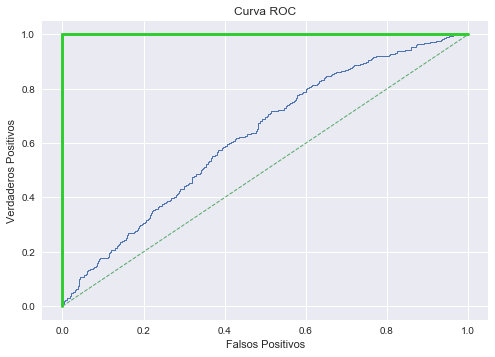

In [120]:
# Plot ROC curve
plt.title('Curva ROC')
plt.plot(false_positive, true_positive, lw=1)
plt.plot([0, 1], ls="--", lw=1)
plt.plot([0, 0], [1, 0] , c='limegreen', lw=3), plt.plot([1, 1] , c='limegreen', lw=3)
plt.ylabel('Verdaderos Positivos')
plt.xlabel('Falsos Positivos');

* A primera vista un modelo con una capacidad predictiva adecuada debe tener una curva por sobre la bisectriz, la cual indica la tasa de clasificación aleatoria. Un modelo con desempeño deficiente presentará curvas ROC bajo la bisectriz.
* Una curva ROC con capacidad predictiva adecuada siempre se posicionará por sobre la bisectriz, dado que la tasa de verdaderos positivos será mayor que la tasa de falsos positivos. El comportamiento deseado de la curva ROC es que tienda a acercarse a la esquina superior izquierda del gráfico, señalada con verde. 
* La calidad de una curva ROC también se puede resumir con una métrica simple llamada la __área debajo de la curva__. Valores mayores de ésta cifra van a estar asociados con un mejor desempeño del modelo en predecir más verdaderos positivos que falsos positivos.
* Para estimar el área debajo de la curva utilizamos el método `roc_auc_score` en el módulo `metrics` de `sklearn`. De manera similar a las implementaciones de métricas previas con `sklearn`, el método solicita el vector objetivo verdadero (`y_test`) y nuestras predicciones en base al modelo (`yhat`).

In [121]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, yhat)

0.6267010096847311

* Con un valor de .64,  nuestro modelo tiene un desempeño de 14% superior a un mecanismo de clasificación aleatoria. Es aceptable, pero se puede mejorar.

## Métodos de resampling (remuestreo)

* En la semana pasada hablamos de los errores en las muestras de entrenamiento y validación medidos mediante el _Promedio del Error Cuadrático_. El error de validación es el costo asociado de un método de aprendizaje estadístico para predecir el objetivo en una nueva observación.
* De esta forma, nuestro criterio para escoger el mejor modelo es aquél que presente un Promedio del Error Cuadrático menor.
* Resulta que muchas veces no tendremos suficientes observaciones en la muestra de validación como para generar un estadístico de error robusto. Para ello aplicamos una estrategia similar, donde separamos de forma repetida en múltiples muestras de entrenamiento y validación.
* Por cada muestra se calcula una métrica de desempeño y posteriormente son promediadas para tener una aproximación al costo asociado de implementar un modelo.

### k-Fold Cross Validation (Validación Cruzada repetida _k_ veces)

* Una de las estrategias más comunes es la segmentación de muestras de tamaño similar _k_ veces, donde _k_ representa la cantidad de segmentaciones a realizar. El procedimiento sigue el siguiente flujo:
    1. Entrenar un modelo con todas las muestras, excluyendo la primera.
    - El modelo entrenado busca predecir el vector objetivo de la primera submuestra, y se calcula algún estadístico de desempeño. Éste se guarda como estadístico de prueba 1.
    - Se vuelve a entrenar el modelo con todas las muestras, volviendo a ingresar la primera muestra y excluyendo la segunda. Se computa el estadístico de desempeño y se guarda como estadístico de prueba 2.
    - Se repite el procedimiento hasta que toda submuestra sea considerada como muestra de validación.
    - Se promedian los estadísticos en una media y desviación estandar.
    
* En la figura generada con `gfx.crossvalidation_schema()` se ejemplifica el procedimiento cuando establecemos $k=5$.

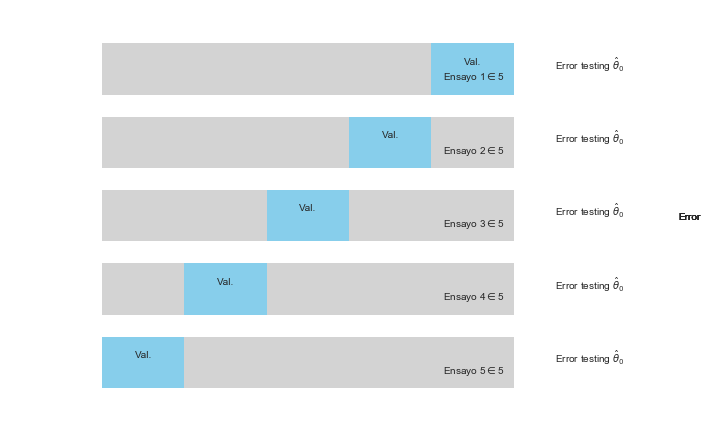

In [122]:
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.axis('off')

def crossvalidation_schema(cv_folds=5,ax= ax, textprop={}):
    """docstring for crossvalidation_schema"""
    for i in range(cv_folds):
        ax.add_patch(plt.Rectangle((0, i), 5, 0.7, fc='lightgrey'))
        ax.add_patch(plt.Rectangle((5. * i /cv_folds, i), 5. / cv_folds, 0.7, fc='skyblue'))
        ax.text(5. * (i + .5) / cv_folds, i + .45, "Val.", ha='center', va='center', **textprop)
        ax.text(5, i + .15, r'Ensayo {0}$\in${1}    '.format(cv_folds - i, cv_folds), ha = 'right', va='bottom', **textprop)
        ax.text(5.5, i + .35, r'Error testing $\hat\theta_{{0}}$'.format(i))
        ax.text(7, 2.3, 'Error')
        ax.set_xlim(-1, 6)
        ax.set_ylim(-0.2, cv_folds + 0.2)
        
        
crossvalidation_schema()

* Para implementar una validación cruzada con `sklearn` importamos el método `cross_val_score` en el módulo `model_selection`. A diferencia de la segmentación de muestras clásica realizada con el método `train_test_split` donde se define el porcentaje a asignar en la muestra de validación, con este método se define la cantidad de submuestras a considerar.
* El método pide los siguientes parámetros:
    1. El primer parámetro corresponde al estimador a utilizar. En este caso utilizaremos `LogisticRegression()`. Cabe destacar que el estimador debe ingresarse como una clase no inicializada.
    - El segundo parámetro es la matriz de atributos. En este caso utilizaremos las cuatro variables definidas en el estudio como `df.loc[:, 'dist100':'assoc']`. Se debe ingresar __toda la matriz de datos__ para realizar la segmentación de forma interna en el modelo.
    - El tercer parámetro es el vector objetivo. En este caso utilizaremos el vector definido en el estudio como `df.loc[:, 'y']`.
    - El cuarto parámetro corresponde a la cantidad de segmentaciones a realizar. En este ejemplo utilizaremos el mínimo posible de segmentaciones con `cv=3`. Si no se define este parámetro, el método asume que son tres segmentaciones.
    - El quinto parámetro corresponde a la métrica de desempeño a evaluar. Si no se define este parámetro, el método asume por defecto que la métrica es `f1` en los modelos de clasificacion y es `mse` (Promedio del Error Cuadrático) en los modelos de regresión. En este caso haremos de forma explícita el uso de `f1`. Para más información sobre los métodos de `scoring` asociados, visiten [http://scikit-learn.org/stable/modules/model_evaluation.html](http://scikit-learn.org/stable/modules/model_evaluation.html).  

In [123]:
from sklearn.model_selection import cross_val_score

m1_cv = cross_val_score(LogisticRegression(), 
                        X=df.loc[:,'dist100':'assoc'],
                        y=df.loc[:, 'y'],
                        cv=3, 
                        scoring='f1')
m1_cv

array([0.70499244, 0.68932806, 0.69954476])

* El método `cross_val_score` devuelve un array con el F1 para cada submuestra.

In [124]:
for i, n in enumerate(m1_cv):
    print("El puntaje F1 para la muestra {0} es {1}".format(i+1, round(n, 2)))

El puntaje F1 para la muestra 1 es 0.7
El puntaje F1 para la muestra 2 es 0.69
El puntaje F1 para la muestra 3 es 0.7


In [125]:
print("El puntaje F1 promedio para el modelo es de: ", round(np.mean(m1_cv), 2))
print("La desviación estandar F1 promedio para el modelo es de: ", round(np.std(m1_cv),2))

El puntaje F1 promedio para el modelo es de:  0.7
La desviación estandar F1 promedio para el modelo es de:  0.01


* Cuando promediamos los puntajes, la evaluación del modelo se mantiene relativamente estable alrededor de un 70% con una desviación estandar baja. En comparación a nuestro F1 original del modelo sin validación cruzada, observamos un incremento de 8% aproximadamente.

### Leave-one-out Crossvalidation (deja-una-afuera)

* De forma opuesta a la _k-Fold_ Cross-Validation encontramos a _Leave-One-Out_ Cross-Validation, caso donde existen tantas muestras como observaciones en una base de datos.
* Bajo este modelo de validación cruzada, se separa una observación a la vez y con las observaciones restantes se entrena un modelo con (n-1) observaciones para predecir su valor. De manera similar a como lo hicimos con _k-Fold_, se genera una métrica de desempeño por cada iteración y posteriormente se promedian.
* La validación _Leave-One-Out_ se implementa dentro del módulo `cross_val_score` en el parámetro `cv` llamando a la clase `LeaveOneOut()`. Si implementamos la validación cruzada con `scoring='f1'`, Python arrojará un error `UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.`, dado que la media harmónica necesita que los valores de Precision y Recall sean mayores a 0. Para este ejemplo utilizaremos `scoring='accuracy'`.
* Otro aspecto a considerar sobre la validación _Leave-one-out_ es el tiempo de ejecución. Jupyter tiene el método `%time` que estima el tiempo en ejecución. El método tiene un tiempo de ejecución de 12.3 segundos, dado que tiene que recorrer por cada observación. Esto es relativamente lento dado el pequeño tamaño muestral.
* __Obs:__ El método `%time` calcula el tiempo de ejecución de toda la celda en la que se encuentra, por lo tanto, si en una celda tenemos, por ejemplo el siguiente código:

```python
%time
myMethod_1(args_1)
print(...)
myMethod_2(args_2)
print(...)
```
El tiempo de ejecución que nos arrojará la celda corresponde al tiempo de ejecución de ambos métodos y de las dos llamadas a la función `print()`.

In [126]:
%%time
from sklearn.model_selection import LeaveOneOut
m1_loocv = cross_val_score(LogisticRegression(), 
                           df.loc[:, 'dist100': 'assoc'], 
                           df.loc[:,'y'], 
                           cv=LeaveOneOut(), # acá asignamos la clase LeaveOneOut()
                           scoring='accuracy')

CPU times: user 12.9 s, sys: 52.9 ms, total: 12.9 s
Wall time: 13 s


In [127]:
# pidamos las primeras 20 observaciones del array
m1_loocv[:20]

array([1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
       1., 1., 1.])

* Resulta que el array arroja valores binarios. Esto se debe a que el método de accuracy cuando se aplica a una observación a la vez, etiqueta como 1 cuando la observación fue predicha de forma exitosa, 0 de lo contrario.

In [128]:
print("El puntaje de accuracy promedio para el modelo es de: ", round(np.mean(m1_loocv), 2))
print("La desviación estandar de accuracy promedio para el modelo es de: ", round(np.std(m1_loocv),2))

El puntaje de accuracy promedio para el modelo es de:  0.61
La desviación estandar de accuracy promedio para el modelo es de:  0.49


* Si comparamos la accuracy promedio estimada con loo (.61) en comparación a la estimada con nuestra estimación original (.63), observamos que disminuyó en 2 puntos aproximadamente. Esto indica cierta inestabilidad de la métrica, punto que ve apoyado por la alta varianza presentada (con una desviación estandar de .49).


### ¿Y qué es mejor?

* Ambos métodos representan extremos sobre cómo realizar segmentaciones para la validación cruzada. La elección del criterio repercute en qué tanto el modelo se acerca a los parámetros verdaderos (sesgo) y qué tan generalizable es nuestro modelo a otras muestras (varianza). Mientras que el número de segmentaciones a realizar aumenta, la diferencia entre los tamaños de las muestras de entrenamiento y validación se reducen. En la medida que ésta diferencia disminuye, el sesgo del modelo disminuye.
* Ya sabemos que en la medida que disminuímos nuestro sesgo, las chances de tener un modelo con alta varianza aumentan substancialmente. Un modelo con alta varianza implica que su replicación en otras muestras puede producir parámetros estimados distintos entre replicaciones.
* Retomando nuestro conocimiento en las leyes asintóticas como el Teorema del Límite Central y la Ley de los Grandes Números, sabemos que en la medida que nuestra muestra (para este caso, la muestra de entrenamiento) aumenta su tamaño, el estimador tenderá a converger con el parámetro verdadero.
* Pongamos a prueba la estimación del puntaje F1 en la medida que aumentamos la cantidad de segmentaciones a realizar. Para este experimento generaremos cuatro validaciones cruzadas con 3, 5, 10 y 20 divisiones, y posteriormente las graficaremos en diagramas de cajas.

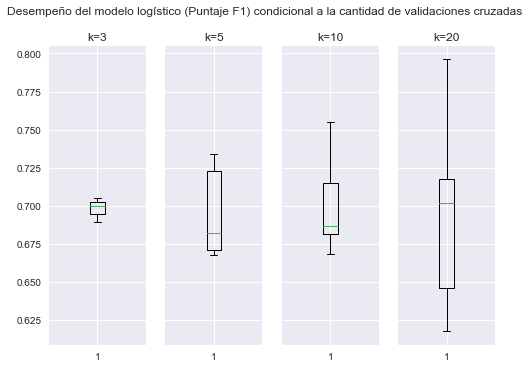

In [129]:
# definimos los criterios en un array
k_fold = [3, 5, 10, 20]
# generamos un gráfico vacío que contenga los gráficos 
fig, ax = plt.subplots(1, len(k_fold), sharey='row')
# por cada elemento y su posición en el array
for n, i in enumerate(k_fold):
    # estimar la validación cruzada con el elemento
    tmp = cross_val_score(LogisticRegression(),
                          df.loc[:, 'dist100':'assoc'],
                          df.loc[:,'y'], cv = i, scoring = 'f1')
    # guardar el gráfico en la posición declarada
    ax[n].boxplot(tmp)
    ax[n].set_title('k={0}'.format(i))

fig.suptitle('Desempeño del modelo logístico (Puntaje F1) condicional a la cantidad de validaciones cruzadas');

* En el gráfico creado se visualiza que el riesgo de utilizar un número alto de segmentaciones (k=20) implica aumentar la variablidad de nuestra métrica de desempeño y levanta dudas sobre la utilidad del modelo para desarrollar nuevas predicciones.
* Cuando el número de validaciones es bajo (k=3), el riesgo es en considerar que la métrica promediada es la óptima. Disminuímos la variabilidad de la predicción a expensas de aumentar el sesgo y obtener un parámetro que dista del óptimo empírico.
* Las situaciones graficadas con k=5 y k=10 se consideran como norma en la cantidad de validaciones a generar. Investigaciones sugieren que se generan resultados similares entre una validación con k=10 y una validación _Leave-one-out_.


# Refactorizando nuestro modelo

* Ahora apliquemos nuestro conocimiento sobre métricas de evaluación para clasificación.
* Nuestro objetivo es desarrollar una serie de aproximaciones funcionales para medir la probabilidad de cambiarse de pozo a uno con menores tasas de arsénico.
* Vamos a generar tres modelos candidatos:

    1. Modelo lineal aditivo: Este es el modelo que desarrollamos anteriormente. Se dice que es _aditivo_ dado que los 4 atributos ingresados no interactúan entre sí.
    - Modelo lineal con interacciones de 2-orden: De forma adicional a los parámetros asignados en el modelo lineal aditivo, agregamos 6 términos que representan interacciones entre dos variables.
    - Modelo lineal con interacciones de 3-orden: Al modelo anterior se le agregan 4 interacciones entre tres variables, resultando en 14 parámetros a estimar.
    

## Generando interacciones

* Para generar las interacciones utilizaremos la clase `PolynomialFeatures()` dentro del módulo `preprocessing` de `sklearn`. Dentro de los parámetros de la clase declaramos las siguientes especificaciones:

    * `degree=2`: Restringimos que el orden de las interacciones no debe superar 2.
    * `interaction_only=True`: Con esta opción ignoramos los términos cuadráticos que se generan por defecto, en adición a las interacciones.
    * `include_bias=False`: Para conservar grados de libertad, ignoramos la estimación del intercepto.
    
* Posteriormente, concatenamos la función `fit_transform` a la clase. Dentro de ella pasamos __las matrices de atributos estandarizadas para entrenamiento y validación__.

### Comparaciones de múltiples métricas

* Ahora implementaremos un flujo para graficar el comporamiento de las métricas _F1_, _Precission_, _Recall_ y _Accuracy_ en los tres modelos mediante validación cruzada. Separaremos el proceso en varios pasos:

#### Generando las matrices a comparar

* Dado que los modelos expanden la cantidad de atributos a incluír, debemos generar las matrices a utilizar. Como utilizaremos la función `cross_val_score`, la matriz de atributos se debe ingresar completa. 


In [130]:
# estandarizamos la matriz de atributos
std_matrix = StandardScaler().fit_transform(df.loc[:, 'dist100':'assoc'])

# Con la clase PolynomialFeature preparamos las otras dos matrices candidatas
from sklearn.preprocessing import PolynomialFeatures

# interacción de 2do orden
df_int_2 = PolynomialFeatures(degree=2, 
                              interaction_only=True, 
                              include_bias=False).fit_transform(std_matrix)
# interacción de 3er orden
df_int_3 = PolynomialFeatures(degree=3, 
                              interaction_only=True, 
                              include_bias=False).fit_transform(std_matrix)

#### Definiendo las métricas

* Para esta evaluación nos enfocaremos en _F1_, _Precision_, _Recall_ y _Accuracy_. Estas las guardaremos en un array (`eval_metrics`) el cual determinará el loop a realizar.
* Generaremos 4 gráficos de caja, uno por cada métrica. Así definimos con `plt.subplots` el rango.
* `plt.xticks` permite rotar las etiquetas del eje X.

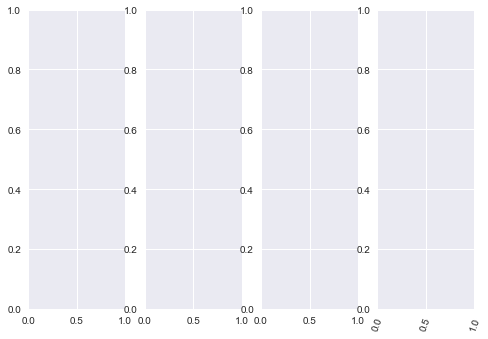

In [131]:
eval_metrics = ['f1', 'precision', 'recall', 'accuracy']
plt.subplots(1, len(eval_metrics))
plt.xticks(rotation=70);

#### Iniciando el loop

* Por cada métrica de `eval_metrics`, solicitaremos lo siguiente:
    1. Calcula los puntajes de validación cruzada con `k=10` para cada modelo candidato.
    - Genera un objeto `DataFrame` para guardar las métricas de forma _larga_ mediante `.unstack()`.
    - Por cada objeto `DataFrame`, graficamos el diagrama de caja.
    - Finiquitamos con detalles estéticos de presentación.

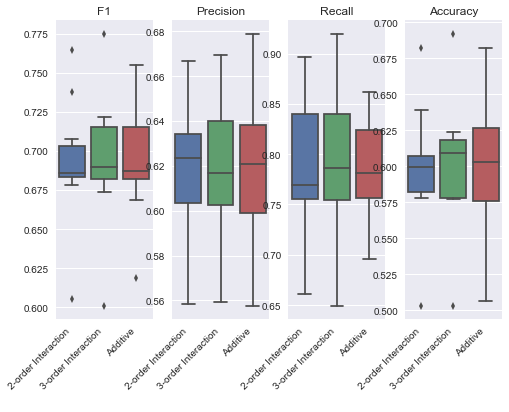

In [132]:
for n, i in enumerate(eval_metrics):
    tmp_1 = cross_val_score(LogisticRegression(),
                          df.loc[:, 'dist100':'assoc'],
                          df.loc[:,'y'], cv = 10, scoring = i)
    tmp_2 = cross_val_score(LogisticRegression(),
                           df_int_2, df.loc[:, 'y'], cv=10, scoring=i)
    tmp_3 = cross_val_score(LogisticRegression(),
                           df_int_3, df.loc[:, 'y'], cv=10, scoring=i)
    
    tmp = pd.DataFrame({'Additive': tmp_1,
                        '2-order Interaction': tmp_2,
                        '3-order Interaction': tmp_3}).unstack().reset_index()
    tmp.rename(columns={'level_0':'order',
                        'level_1': 'num',
                        '0': 'score'}, inplace=True)
    plt.subplot(1, 4, n+1)
    sns.boxplot(tmp.iloc[:,0],
                tmp.iloc[:, 2])
    sns.despine()
    plt.xticks(rotation=45, ha='right')
    plt.xlabel(' ')
    plt.ylabel(' ')
    plt.title(i.capitalize());

#### ¿Y cuál modelo es el mejor?

* Enfoquémonos en las métricas `F1`. El gráfico sugiere que el modelo con un mejor desempeño es el con interacciones del tercer orden. Esto dado que presenta una mediana relativamente superior a las métricas de los otros modelos. También cabe destacar que si bien presenta una mayor varianza que el modelo con interacciones del segundo orden, presenta menos casos atípicos.
* Otro aspecto favorable al modelo con interacciones del tercer orden es que tanto Precision como Recall son relativamente similares en mediana y varianza, en comparación a los otros modelos candidatos. Finalmente, el modelo también presenta mayores tasas de exactitud en la predicción general.

### Expansión de n-orden

* En este caso generaremos otra validación, incluyendo tanto términos de interacción como polinomiales en los modelos. De similar manera al ejemplo anterior generamos un array que contenga el orden polinómico a incluir.
* Para este caso utilizaremos la métrica _AUC_ y la curva _ROC_ que informa sobre la relación entre falsos y verdaderos positivos. Veremos cómo se comporta en la medida que aumentamos la complejidad del modelo. 
* Para este ejemplo utilizaremos los polinomios 5, 10, 15, 20 y 25, en adición al modelo lineal simple.

Orden: 1, cantidad de atributos estimables: 4. AUC estimada: 0.642
Orden: 5, cantidad de atributos estimables: 125. AUC estimada: 0.662
Orden: 10, cantidad de atributos estimables: 1000. AUC estimada: 0.599
Orden: 15, cantidad de atributos estimables: 3875. AUC estimada: 0.614
Orden: 20, cantidad de atributos estimables: 10625. AUC estimada: 0.576
Orden: 25, cantidad de atributos estimables: 23750. AUC estimada: 0.544


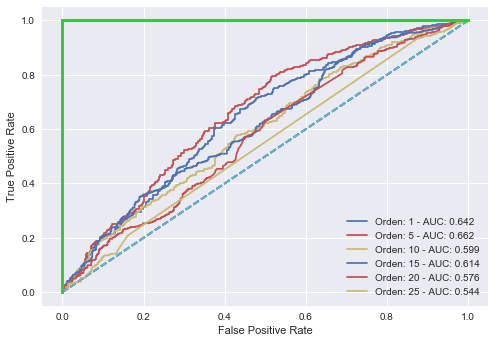

In [133]:
# estandarizamos la matriz de datos
std_matrix = StandardScaler().fit_transform(df.loc[:, 'dist100':'assoc'])
#declaramos los términos
polynomial_order = [1, 5, 10, 15, 20, 25]
# por cada elemento del array
for i in polynomial_order:
    #generamos muestras segmentadas
    X_train_tmp, X_test_tmp, y_train_tmp, y_test_tmp = train_test_split(std_matrix,
                                               df['y'],
                                               test_size=.33,
                                               random_state=11238)
    # Transformamos la muestra de entrenamiento por i polinomio
    X_train_tmp = PolynomialFeatures(degree=i,
                                     interaction_only=False,
                                     include_bias=False).fit_transform(X_train_tmp)
    # Transformamos la muestra de evaluación por i polinomio
    X_test_tmp = PolynomialFeatures(degree=i,
                                    interaction_only=False,
                                    include_bias=False).fit_transform(X_test_tmp)
    # Generamos el modelo predictivo
    tmp_model = LogisticRegression().fit(X_train_tmp, y_train_tmp)
    # Guardamos las predicciones de probabilidad
    tmp_pred = tmp_model.predict_proba(X_test_tmp)[:,1]
    # generamos los arrays con roc_curve
    false_positive, true_positive, threshold = roc_curve(y_test_tmp,
                                                         tmp_pred)
    # redondeamos los valores del puntaje AUC
    roc_auc_tmp = round(roc_auc_score(y_test_tmp, tmp_pred), 3)
    # graficamos
    plt.plot(false_positive,
             true_positive,
             label = 'Orden: {0} - AUC: {1}'.format(i, roc_auc_tmp))
    plt.plot([0, 1], ls="--")
    plt.plot([0, 0], [1, 0] , c='limegreen', lw=3),
    plt.plot([1, 1] , c='limegreen', lw=3)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend()
    # solicitamos información de iteración
    print("Orden: {0}, cantidad de atributos estimables: {1}. AUC estimada: {2}".format(i, X_train_tmp.shape[1], roc_auc_tmp))    

* El output del experimento demuestra que el aumentar la complejidad del modelo (medida en la cantidad de parámetros), esta no conlleva a un aumento monotónico del desempeño del modelo. 
* Consideremos los últimos dos modelos, donde se permitieron interacciones y polinomios del 20-orden. Estos casos tienen un desempeño magro con 4% y 7% mayores chances de clasificar correctamente una observación, en comparación a un clasificador aleatorio.
* Guiándonos por los principios de la parsimonía, preferiremos un modelo que maximize nuestra tasa de clasificación __con la menor cantidad de variables__. Esto se cumple con el modelo del 5-orden, con un desempeño 16% superior que un clasificador aleatorio. Otro aspecto a considerar es que el modelo del 5-orden es eficiente en términos computacionales, dado que se demora menos tiempo en ejecutar.
* Finalmente cabe señalar que el modelo sin términos polinomiales tiene un desempeño relativamente adecuado (comparado entre todos los modelos candidatos). Así, la moraleja es no colapsar de forma prematura nuestros modelos predictivos con características innecesarias.

* En la próxima sesión utilizaremos algoritmos para reducir la dimensionalidad de nuestras observaciones para resolver problemas como el recientemente desarrollado, donde la cantidad de atributos en nuestra matriz X afecta en términos computacionales y asintóticos el desempeño de nuestros modelos.

# Referencias

* El ejemplo de la lectura proviene de _Gelman, A., & Hill, J. (2006). Data analysis using regression and multilevel/hierarchical models. Analytical Methods for Social Research. New York: Cambridge University Press._ Capítulo 5. Esta lectura se sugiere para profundizar sobre los aspectos econométricos del modelo logístico. El capítulo 6 expande el marco analítico hacia los _Modelo Lineales Generalizados_, donde nuestro vector objetivo se puede aproximar asintóticamente con distribuciones complejas.
* La explicación más concisa respecto a la validación cruzada y métricas de desarrollo se puede encontrar en _Kuhn, M., & Johnson, K. (2013). Applied predictive modeling (Vol. 26). New York: Springer._ Capítulos 3 (Validación Cruzada) y 11 (Métricas de desempeño en clasificación).
* Profundizaciones en los aspectos más formales sobre los modelos de clasificación se encuentran en _Murphy, K. 2012. Machine Learning: A Probabilistic Perspective. Cambridge, MA: MIT Press._ Capítulo 8 (Regresión Logística) y _Hastie, T; Tibshirani, R y Freedman, D. 2009. The Elements of Statistical Learning. Springer-Verlag Press._ Capítulo 4 (Modelos Lineales para Clasificación).